# Wikipedia Pipeline: FIGRL test

Before the pipeline for the Stanford Wikipedia dataset kicks off, some global parameters need to be defined. We devised a manual
`kfold`-fold out-of-time validation, by dividing the dataset based on a rolling window approach. `timeframe`specifes which timeframe is selected. The `embedding_size`defines the dimension of the embeddings learned by Fast Inductive Graph Representation Learning algorithm. The `intermediate_dimension` is given by choosing an appropriate approximation ratio by the following formula: `intermediate_dimension` = max{4log(amount of nodes)/e^2, k/e^2} with e the approximation ratio and k the final embeddings_size.

In [1]:
# Global parameters:
kfold = 5
timeframe = 2
embedding_size = 40
intermediate_dimension = 400

## 1. Loading the Wikipedia Dataset

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd 
import numpy as np
import time
import dateparser
import networkx as nx
import scipy
from scipy.sparse import csr
import scipy.sparse

In [3]:
df = pd.read_csv("C:\\Users\\hendr\\OneDrive\\Documents\\KU Leuven Job\\datasets\\wikipedia.csv",header=None, skiprows=1)
df = df.set_index(df.index+1)

In [4]:
column_name = ['user_id','item_id','timestamp','state_label']
column_name.extend(range(4,176))
df.columns = column_name

In [5]:
df['user_id']+=max(df.index)+1
df['item_id']+=max(df.user_id)+1
print(min(df.item_id))

165702


def split(x, n): 
    split_list = []
    if(x < n):  
        print(-1) 
    elif (x % n == 0): 
        for i in range(n): 
            split_list.append(x//n) 
    else: 
        zp = n - (x % n) 
        pp = x//n 
        for i in range(n): 
            if(i>= zp): 
                split_list.append(pp + 1) 
            else: 
                split_list.append(pp) 
    return split_list

split_list = split(672447,kfold)
split_list
k = 0
for i in range(0,kfold):
    k+=split_list[i]
    split_list[i]=k

begin_id = split_list[timeframe-2]
end_id = split_list[timeframe-1]

data_timeframe = df.iloc[begin_id:end_id,:]
cutoff = round(0.6*len(data_timeframe))
train_data = data_timeframe.head(cutoff)
inductive_data = data_timeframe.tail(len(data_timeframe)-cutoff)

In [6]:
cutoff = round(0.6*len(df))
train_data = df.head(cutoff)
inductive_data = df.tail(len(df)-cutoff)

In [7]:
print('The distribution of banned pages for the train data is:\n', train_data['state_label'].value_counts())
print('The distribution of banned pages for the inductive data is:\n', inductive_data['state_label'].value_counts())

The distribution of banned pages for the train data is:
 0    94349
1      135
Name: state_label, dtype: int64
The distribution of banned pages for the inductive data is:
 0    62908
1       82
Name: state_label, dtype: int64


### 1.1 Undersampling

In [8]:
undersampling_rate = None

In [9]:
from imblearn.under_sampling import RandomUnderSampler

if not undersampling_rate is None:
    print("An undersampling rate of ", undersampling_rate, "is applied.")
    train_data['index'] = train_data.index
    undersample = RandomUnderSampler(sampling_strategy=(undersampling_rate))
    X, y = undersample.fit_resample(train_data, train_data['state_label'])
    train_data = X.set_index(X['index']).drop('index',axis=1)
    print('The new distribution for the train set is:\n', train_data["state_label"].value_counts())


Using TensorFlow backend.


## 2. Construct the Graph Network

A networkx graph is constructed with edit, user and webpage nodes. Creating a three partite graph. The FI-GRL framework derives embeddings starting from an adjacency matrix that it constructs using the graph's edgelist. 

In [10]:
nodes = {"edit":train_data.index, "user":train_data.user_id, "webpage":train_data.item_id}
edges = [zip(train_data.user_id, train_data.index),zip(train_data.item_id, train_data.index)]
g_nx = nx.Graph()
for key, values in nodes.items():
            g_nx.add_nodes_from(values, ntype=key)
for edge in edges:
            g_nx.add_edges_from(edge)

## 3. Train FIGRL

FI-GRL, a fast inductive graph representation framework is trained using the aforeconstructed graph. This algorithm is implemented in matlab so we make use of matlab.engine to deploy its native implementation. First, we instantiate the FI-GRL class with the intermediate dimension of the matrix between the input graph and the embedding space, in addition to the size of final dimension (embedding space). FI-GRL's train step returns three matrices: U, which represents the embedding space, sigma and v, which are matrices that will be used in the inductive step to generate embeddings for unseen nodes. 

In [11]:
from FIGRL import FIGRL

In [12]:
figrl = FIGRL(embedding_size, intermediate_dimension)
figrl_train_emb = figrl.train(g_nx)
figrl_train_emb = figrl_train_emb.loc[train_data.index]

## 4. Inductive Step

In [13]:
pd.options.mode.chained_assignment = None

inductive_graph_data = pd.concat((train_data,inductive_data))

In [14]:
nodes = {"edit":inductive_graph_data.index, "user":inductive_graph_data.user_id, "webpage":inductive_graph_data.item_id}
edges = [zip(inductive_graph_data.user_id, inductive_graph_data.index),zip(inductive_graph_data.item_id, inductive_graph_data.index)]
graph_full = nx.Graph()

for key, values in nodes.items():
            graph_full.add_nodes_from(values, ntype=key)
for edge in edges:
            graph_full.add_edges_from(edge)

In [15]:
import collections

inductive_dict = {}
for node in inductive_data.index:
    user = inductive_data.loc[node].user_id
    item = inductive_data.loc[node].item_id
    inductive_dict[node] = [user,item]
inductive_dict = collections.OrderedDict(sorted(inductive_dict.items()))

In [16]:
figrl_inductive_emb = figrl.inductive_step(graph_full, inductive_dict, max(inductive_graph_data.item_id), inductive_data.index)

creating sparse vector matrix


## 5. Evaluation

In [17]:
from xgboost import XGBClassifier
classifier = XGBClassifier(n_estimators=100)

In [18]:
figrl_inductive_emb

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
94485,0.000341,0.000791,0.001113,0.000434,0.000255,-0.001020,0.000003,0.000216,-0.000992,-0.000103,...,-0.000361,-0.001476,-0.000302,-0.000377,-0.000907,-0.000660,-0.000990,0.000205,0.000612,0.001445
94486,0.000129,0.000074,-0.000199,-0.000276,0.000325,0.000313,0.000093,0.000189,-0.000574,-0.000285,...,0.000101,-0.000397,0.000174,0.000448,-0.000257,0.000857,-0.000749,0.000048,-0.000102,-0.000097
94487,0.000087,0.001248,-0.000025,0.000515,0.001128,0.000284,-0.000065,0.000508,-0.000142,0.000764,...,-0.000266,-0.000803,-0.001470,0.000194,-0.000757,-0.000032,0.000117,0.000242,-0.000919,0.000610
94488,0.000300,0.000324,-0.001119,0.000454,0.000444,0.000774,0.000576,0.000072,0.000056,0.000797,...,0.000289,-0.000569,-0.001507,-0.000222,0.000052,-0.000282,-0.000035,-0.000223,0.000949,0.000362
94489,0.000203,-0.000700,0.000397,0.000902,0.000042,0.000404,0.000054,0.000184,0.000863,0.001251,...,-0.000202,-0.001061,-0.000553,0.000494,-0.000077,-0.000380,0.000151,0.000282,-0.000291,0.000219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157470,0.000519,0.001350,0.000264,-0.000934,0.000273,0.001328,0.000435,0.000162,-0.000038,-0.000711,...,-0.001332,-0.000765,-0.001204,-0.000215,-0.001053,-0.000814,-0.000666,0.000232,0.000471,0.000866
157471,-0.000716,0.000274,-0.000184,-0.000618,0.000219,0.000218,0.000447,0.000720,-0.000578,-0.000852,...,-0.000115,-0.000235,-0.000334,0.000067,0.001409,-0.000549,0.000199,0.000697,-0.000425,0.000696
157472,0.000310,0.000650,0.000288,-0.000488,-0.000030,0.000624,0.001157,-0.000647,-0.000140,0.000928,...,0.000284,-0.000730,0.000794,-0.000154,0.000235,0.000464,0.000269,0.000068,-0.000397,-0.000249
157473,0.000016,0.001195,-0.000125,0.000079,-0.000121,-0.000557,0.000192,0.001236,0.000572,0.000261,...,-0.000214,0.001244,-0.000703,-0.000377,-0.001977,0.000996,-0.000344,0.000563,0.000453,0.001369


In [19]:
train_labels = train_data['state_label']
figrl_train_emb = pd.merge(figrl_train_emb, train_data.loc[figrl_train_emb.index].drop('state_label', axis=1), left_index=True, right_index=True)
figrl_inductive_emb = pd.merge(figrl_inductive_emb, inductive_data.loc[figrl_inductive_emb.index].drop('state_label', axis=1), left_index=True, right_index=True)

baseline_train = train_data.drop('state_label', axis=1)
baseline_inductive = inductive_data.drop('state_label', axis=1)

classifier.fit(baseline_train, train_labels)
baseline_predictions = classifier.predict_proba(baseline_inductive)
    
classifier.fit(figrl_train_emb, train_labels)
predictions = classifier.predict_proba(figrl_inductive_emb)


In [20]:
import scikitplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from matplotlib import pyplot

def pr_curve(probabilities, labels, name):

        """
        This function plots the precision recall curve for the used classification model and a majority classifier.
        
        """
        probs = probabilities[:, 1]
        precision, recall, _ = precision_recall_curve(labels, probs)
        pyplot.plot(recall, precision, label=name)
        # axis labels
        pyplot.xlabel('Recall')
        pyplot.ylabel('Precision')
        # show the legend
        pyplot.legend()
        
        print('Average precision-recall score for ', name, ' configuration XGBoost: {0:0.10f}'.format(average_precision_score(labels, probs)))

Average precision-recall score for  FI-GRL  configuration XGBoost: 0.0377795219
Average precision-recall score for  Baseline  configuration XGBoost: 0.0214397362


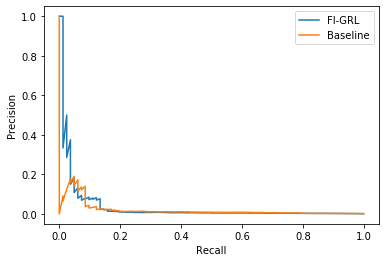

In [21]:
inductive_labels = df.loc[figrl_inductive_emb.index]['state_label']

pr_curve(predictions, inductive_labels, "FI-GRL")

pr_curve(baseline_predictions, inductive_labels, "Baseline")